# dvdrental Database Analysis and Visualization

This notebook analyzes and visualizes some patterns in the dvdrental PostgreSQL database using pandas, matplotlib, and SQLAlchemy.

In [1]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [ ]:
# Set Up Database Connection
DB_HOST = 'localhost'
DB_PORT = 5432
DB_NAME = 'dvdrental'
DB_USER = 'postgres'
DB_PASS = '222'

# SQLAlchemy connection string
conn_str = f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

In [3]:
# Fetch Monthly Sales Data
def fetch_monthly_sales():
    query = '''
    SELECT TO_CHAR(payment_date, 'YYYY-MM') AS month, SUM(amount) AS total_sales
    FROM payment
    GROUP BY month
    ORDER BY month;
    '''
    engine = create_engine(conn_str)
    df = pd.read_sql_query(query, engine)
    engine.dispose()
    return df

monthly_sales_df = fetch_monthly_sales()
monthly_sales_df.head()

,month,total_sales
0,2007-02,8351.84
1,2007-03,23886.56
2,2007-04,28559.46
3,2007-05,514.18


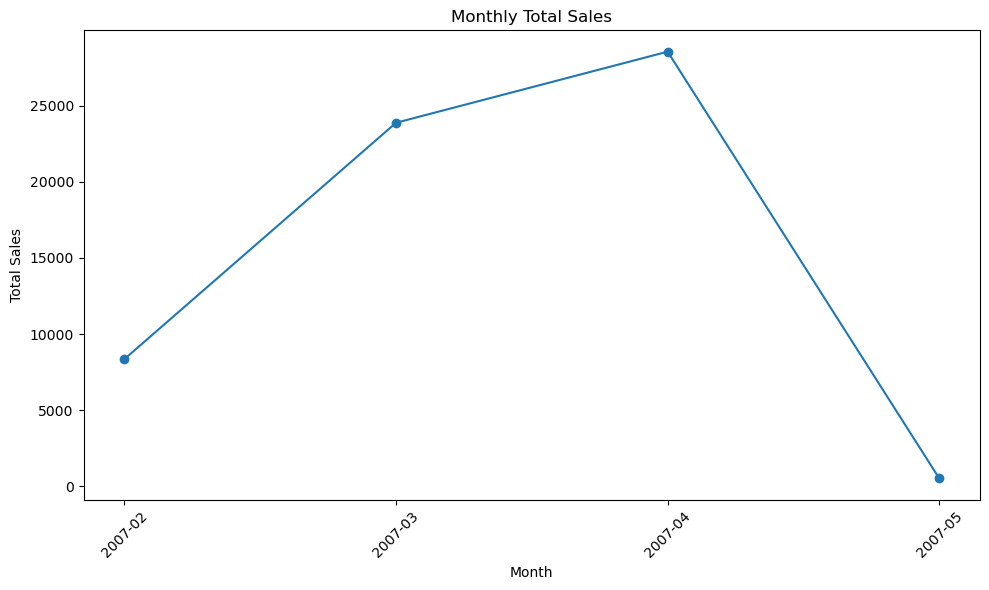

In [4]:
# Plot Monthly Sales Trend
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales_df['month'], monthly_sales_df['total_sales'], marker='o')
plt.title('Monthly Total Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Fetch Top Film Categories
def fetch_top_categories():
    query = '''
    SELECT name AS category, COUNT(*) AS film_count
    FROM category
    JOIN film_category USING (category_id)
    GROUP BY name
    ORDER BY film_count DESC
    LIMIT 10;
    '''
    engine = create_engine(conn_str)
    df = pd.read_sql_query(query, engine)
    engine.dispose()
    return df

top_categories_df = fetch_top_categories()
top_categories_df

,category,film_count
0,Sports,74
1,Foreign,73
2,Family,69
3,Documentary,68
4,Animation,66
5,Action,64
6,New,63
7,Drama,62
8,Sci-Fi,61
9,Games,61


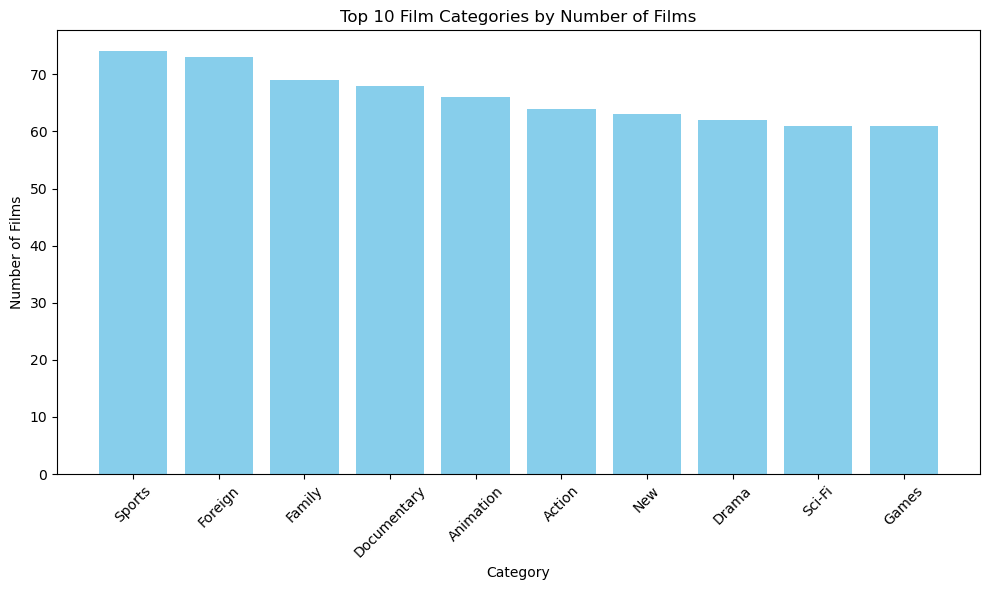

In [6]:
# Plot Top Film Categories (Bar Chart)
plt.figure(figsize=(10, 6))
plt.bar(top_categories_df['category'], top_categories_df['film_count'], color='skyblue')
plt.title('Top 10 Film Categories by Number of Films')
plt.xlabel('Category')
plt.ylabel('Number of Films')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Fetch Film Ratings Distribution
def fetch_ratings_distribution():
    query = '''
    SELECT rating, COUNT(*) AS film_count
    FROM film
    GROUP BY rating
    ORDER BY film_count DESC;
    '''
    engine = create_engine(conn_str)
    df = pd.read_sql_query(query, engine)
    engine.dispose()
    return df

ratings_df = fetch_ratings_distribution()
ratings_df

,rating,film_count
0,PG-13,223
1,NC-17,210
2,R,195
3,PG,194
4,G,178


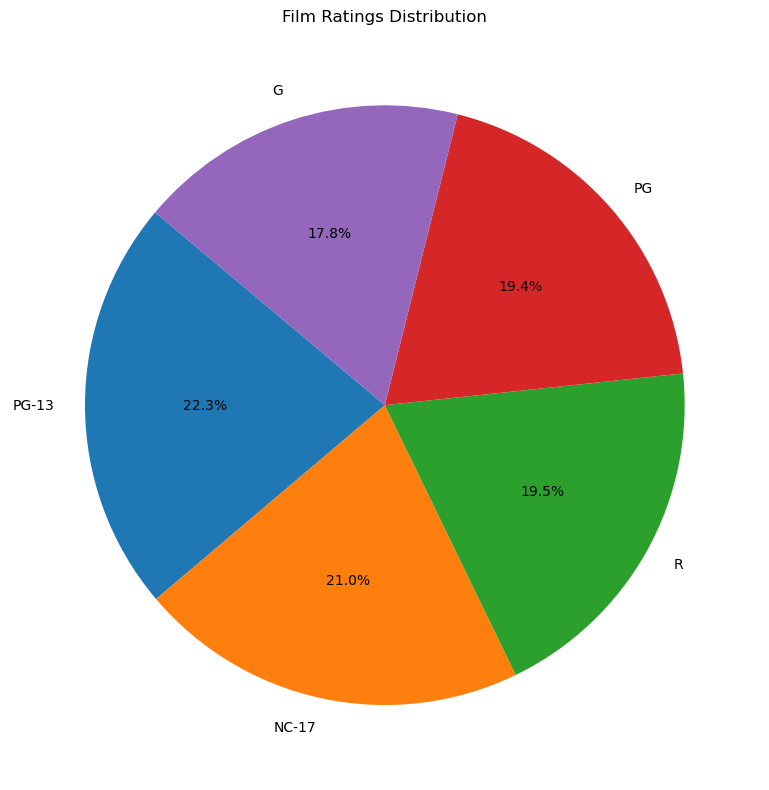

In [8]:
# Plot Film Ratings Distribution (Pie Chart)
plt.figure(figsize=(8, 8))
plt.pie(ratings_df['film_count'], labels=ratings_df['rating'], autopct='%1.1f%%', startangle=140)
plt.title('Film Ratings Distribution')
plt.tight_layout()
plt.show()

In [9]:
# Fetch Top Categories by Sales
def fetch_top_categories_by_sales():
    query = '''
    SELECT c.name AS category, SUM(p.amount) AS total_sales
    FROM payment p
    JOIN rental r ON p.rental_id = r.rental_id
    JOIN inventory i ON r.inventory_id = i.inventory_id
    JOIN film f ON i.film_id = f.film_id
    JOIN film_category fc ON f.film_id = fc.film_id
    JOIN category c ON fc.category_id = c.category_id
    GROUP BY c.name
    ORDER BY total_sales DESC
    LIMIT 10;
    '''
    engine = create_engine(conn_str)
    df = pd.read_sql_query(query, engine)
    engine.dispose()
    return df

top_sales_df = fetch_top_categories_by_sales()
top_sales_df

,category,total_sales
0,Sports,4892.19
1,Sci-Fi,4336.01
2,Animation,4245.31
3,Drama,4118.46
4,Comedy,4002.48
5,New,3966.38
6,Action,3951.84
7,Foreign,3934.47
8,Games,3922.18
9,Family,3830.15


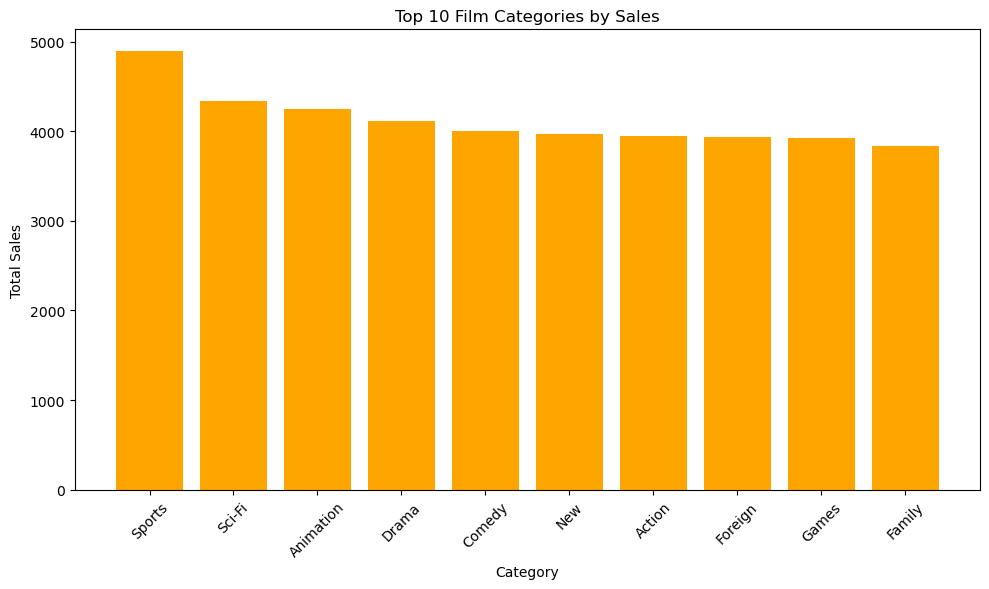

In [10]:
# Plot Top Categories by Sales (Bar Chart)
plt.figure(figsize=(10, 6))
plt.bar(top_sales_df['category'], top_sales_df['total_sales'], color='orange')
plt.title('Top 10 Film Categories by Sales')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Deeper Pattern: Top Customers by Total Spending

Let's find the customers who spent the most in the dvdrental database.

In [11]:
# Fetch Top Customers by Total Spending
def fetch_top_customers():
    query = '''
    SELECT c.first_name || ' ' || c.last_name AS customer, SUM(p.amount) AS total_spent
    FROM payment p
    JOIN customer c ON p.customer_id = c.customer_id
    GROUP BY c.customer_id, c.first_name, c.last_name
    ORDER BY total_spent DESC
    LIMIT 10;
    '''
    engine = create_engine(conn_str)
    df = pd.read_sql_query(query, engine)
    engine.dispose()
    return df

top_customers_df = fetch_top_customers()
top_customers_df

,customer,total_spent
0,Eleanor Hunt,211.55
1,Karl Seal,208.58
2,Marion Snyder,194.61
3,Rhonda Kennedy,191.62
4,Clara Shaw,189.60
5,Tommy Collazo,183.63
6,Ana Bradley,167.67
7,Curtis Irby,167.62
8,Marcia Dean,166.61
9,Mike Way,162.67


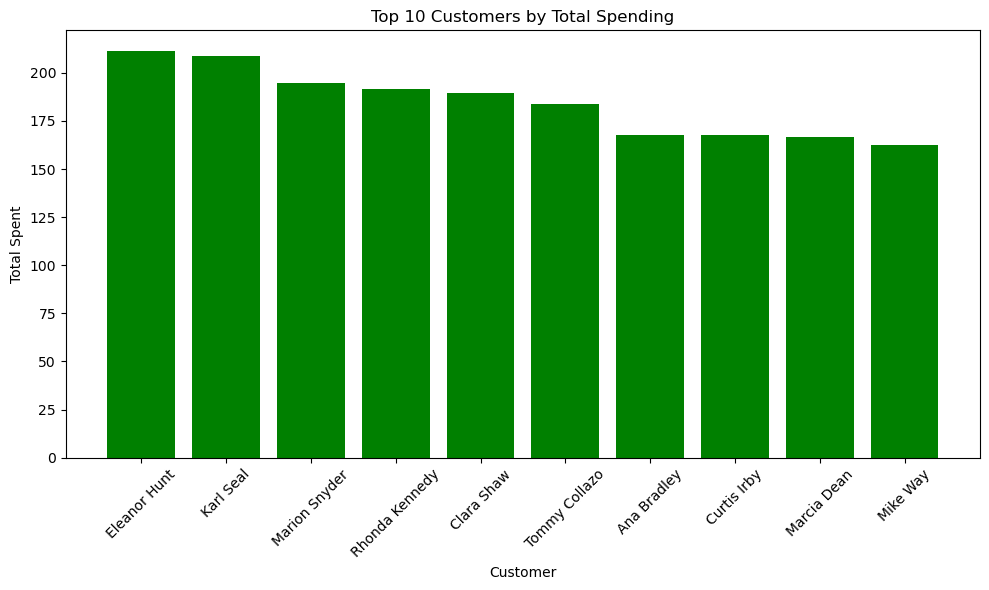

In [12]:
# Plot Top Customers by Total Spending (Bar Chart)
plt.figure(figsize=(10, 6))
plt.bar(top_customers_df['customer'], top_customers_df['total_spent'], color='green')
plt.title('Top 10 Customers by Total Spending')
plt.xlabel('Customer')
plt.ylabel('Total Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Deeper Pattern: Correlation Between Film Length and Rental Frequency

Let's analyze whether longer or shorter films are rented more often. We'll calculate the correlation and visualize it.

In [13]:
# Fetch Film Length and Rental Frequency
def fetch_length_vs_rentals():
    query = '''
    SELECT f.length, COUNT(r.rental_id) AS rental_count
    FROM film f
    JOIN inventory i ON f.film_id = i.film_id
    JOIN rental r ON i.inventory_id = r.inventory_id
    GROUP BY f.film_id, f.length
    ORDER BY f.length;
    '''
    engine = create_engine(conn_str)
    df = pd.read_sql_query(query, engine)
    engine.dispose()
    return df

length_rentals_df = fetch_length_vs_rentals()
length_rentals_df.head()

,length,rental_count
0,46,15
1,46,23
2,46,22
3,46,11
4,46,32


Correlation between film length and rental frequency: -0.03


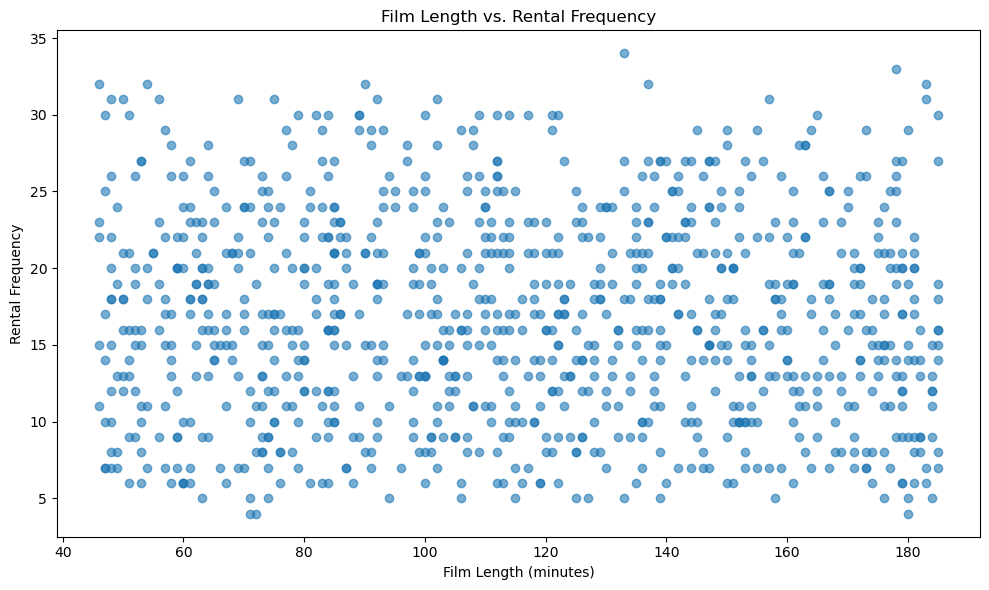

In [14]:
# Compute correlation and plot scatter plot
correlation = length_rentals_df['length'].corr(length_rentals_df['rental_count'])
print(f'Correlation between film length and rental frequency: {correlation:.2f}')

plt.figure(figsize=(10, 6))
plt.scatter(length_rentals_df['length'], length_rentals_df['rental_count'], alpha=0.6)
plt.title('Film Length vs. Rental Frequency')
plt.xlabel('Film Length (minutes)')
plt.ylabel('Rental Frequency')
plt.tight_layout()
plt.show()